In [1]:
# rice_agent.py
import os
from pathlib import Path
from typing import List, Dict, TypedDict, Any

from dotenv import load_dotenv
from qdrant_client import QdrantClient
from openai import OpenAI

from langchain.schema import Document
from langchain_core.retrievers import BaseRetriever
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain.tools import tool
from pydantic import BaseModel, Field

# ----------------------------
# Env & clients
# ----------------------------
load_dotenv()
env_path = Path('.') / '.env'
if env_path.exists():
    with open(env_path) as f:
        for line in f:
            if '=' in line and not line.strip().startswith('#'):
                key, value = line.strip().split('=', 1)
                os.environ.setdefault(key, value)

QDRANT_URL = os.environ["QDRANT_URL"]
QDRANT_API_KEY = os.environ["QDRANT_API_KEY"]
COLLECTION_NAME = os.environ["QDRANT_COLLECTION_NAME"]
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

qdrant = QdrantClient(url=QDRANT_URL, api_key=QDRANT_API_KEY)
openai_client = OpenAI(api_key=OPENAI_API_KEY)

# ----------------------------
# Helpers
# ----------------------------
def get_query_embedding(text: str) -> List[float]:
    resp = openai_client.embeddings.create(model="text-embedding-3-small", input=text)
    return resp.data[0].embedding

def _as_documents(results) -> List[Document]:
    docs: List[Document] = []
    for r in results:
        payload: Dict = r.payload or {}
        docs.append(
            Document(
                page_content=payload.get("content", ""),
                metadata={
                    "score": r.score,
                    "title": payload.get("title", ""),
                    "summary": payload.get("summary", ""),
                    "url": payload.get("url", ""),
                    "source": payload.get("source", ""),
                    "chunk_id": payload.get("chunk_id", ""),
                }
            )
        )
    return docs

def format_document_details(docs: List[Document]) -> str:
    blocks = []
    for doc in docs:
        meta = doc.metadata or {}
        blocks.append(
            f"- Title: {meta.get('title', 'No title')} (score: {meta.get('score', 0):.3f})\n"
            f"  URL: {meta.get('url', 'N/A')}\n"
            f"  Source: {meta.get('source', 'N/A')}\n"
            f"  Summary: {meta.get('summary', '')[:150]}...\n"
            f"  Preview: {doc.page_content[:150]}...\n"
        )
    return "\n".join(blocks) if blocks else "_No sources found._"

# ----------------------------
# TOOLS (Qdrant + Neo4j stub)
# ----------------------------
@tool("qdrant_search", return_direct=False)
def qdrant_search(query: str, k: int = 5, threshold: float = 0.35) -> Dict[str, Any]:
    """
    Vector search over Qdrant. Args:
      query: natural language query
      k: number of hits
      threshold: score threshold (0-1)
    Returns: dict with 'hits' list -> each hit has content + metadata
    """
    print(f"[tool:qdrant_search] query='{query}', k={k}, threshold={threshold}")
    emb = get_query_embedding(query)
    results = qdrant.search(
        collection_name=COLLECTION_NAME,
        query_vector=emb,
        limit=k,
        with_payload=True,
        with_vectors=False,
        score_threshold=threshold
    )
    hits = []
    for r in results:
        payload = r.payload or {}
        hits.append({
            "score": r.score,
            "content": payload.get("content", ""),
            "title": payload.get("title", ""),
            "summary": payload.get("summary", ""),
            "url": payload.get("url", ""),
            "source": payload.get("source", ""),
            "chunk_id": payload.get("chunk_id", "")
        })
    print(f"[tool:qdrant_search] returned {len(hits)} hits")
    return {"hits": hits}

@tool("neo4j_kg_search", return_direct=False)
def neo4j_kg_search(query: str, limit: int = 5) -> Dict[str, Any]:
    """
    (Stub) Search entities/relations in a Neo4j knowledge graph.
    Replace with real Cypher query logic and driver usage.
    """
    print(f"[tool:neo4j_kg_search] query='{query}', limit={limit}")
    # TODO: implement your real KG search here
    # Return a normalized structure so the collector can handle it
    return {"hits": []}

TOOLS = [qdrant_search, neo4j_kg_search]

# ----------------------------
# LLMs and prompts
# ----------------------------
rag_template = """
You are RiceAI Expert, a trusted agronomist and AI agent trained on sustainable and high-yield rice farming practices.

When answering the question, use all relevant context provided. Explain the answer thoroughly and cover all key details, so that no important information is omitted. Be explicit and comprehensive.

Chat history: {history}

Retrieved context: {context}

Question: {question}
"""
rag_prompt = ChatPromptTemplate.from_template(rag_template)
rag_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=OPENAI_API_KEY)
rag_chain = rag_prompt | rag_llm

# A small planner LLM that decides which tool(s) to call
planner_system = SystemMessage(content=(
    "You are a retrieval planner. Decide which tools to call to fetch context for the user's question.\n"
    "If the question requires vector semantic search, call qdrant_search.\n"
    "If a knowledge graph lookup would help, call neo4j_kg_search.\n"
    "Keep calls minimal but sufficient. If in doubt, call qdrant_search first.\n"
))
planner_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=OPENAI_API_KEY).bind_tools(TOOLS)

# ----------------------------
# State + Models
# ----------------------------
class AgentState(TypedDict):
    messages: List[BaseMessage]
    documents: List[Document]
    on_topic: str
    rephrased_question: str
    proceed_to_generate: bool
    rephrase_count: int
    question: HumanMessage

class GradeQuestion(BaseModel):
    score: str = Field(..., description="Respond with 'Yes' or 'No'")

class GradeDocument(BaseModel):
    score: str = Field(..., description="Respond with 'Yes' or 'No'")

# ----------------------------
# Nodes
# ----------------------------
def question_rewriter(state: AgentState) -> AgentState:
    print("=== Entering question_rewriter ===")
    # reset
    state["documents"] = []
    state["on_topic"] = ""
    state["rephrased_question"] = ""
    state["proceed_to_generate"] = False
    state["rephrase_count"] = 0

    state.setdefault("messages", [])
    if state["question"] not in state["messages"]:
        state["messages"].append(state["question"])

    if len(state["messages"]) > 1:
        conversation = state["messages"][:-1]
        current_question = state["question"].content
        messages: List[BaseMessage] = [
            SystemMessage(content="Rephrase the user's last question as a standalone query optimized for retrieval.")
        ]
        messages.extend(conversation)
        messages.append(HumanMessage(content=current_question))
        rephrase_prompt = ChatPromptTemplate.from_messages(messages)
        resp = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=OPENAI_API_KEY).invoke(rephrase_prompt.format())
        better = resp.content.strip()
        print(f"[question_rewriter] Rephrased: {better}")
        state["rephrased_question"] = better
    else:
        state["rephrased_question"] = state["question"].content
        print(f"[question_rewriter] No history; using original: {state['rephrased_question']}")
    return state

def question_classifier(state: AgentState) -> AgentState:
    print("=== Entering question_classifier ===")
    system_message = SystemMessage(
        content=("You are a classifier that determines whether a user's question is about rice farming. "
                 "Topics: cultivation, water, fertilizer, organic vs inorganic, sustainability, pest mgmt, harvesting, etc. "
                 "If relevant, answer 'Yes', otherwise 'No'.")
    )
    human_message = HumanMessage(content=f"User question: {state['rephrased_question']}")
    grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    grader_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=OPENAI_API_KEY).with_structured_output(GradeQuestion)
    result = (grade_prompt | grader_llm).invoke({})
    state["on_topic"] = result.score.strip()
    print(f"[question_classifier] on_topic = {state['on_topic']}")
    return state

def on_topic_router(state: AgentState) -> str:
    print("=== Entering on_topic_router ===")
    route = "retrieve_planner" if state.get("on_topic", "").strip().lower() == "yes" else "off_topic_response"
    print(f"[on_topic_router] Routing -> {route}")
    return route

def retrieve_planner(state: AgentState) -> AgentState:
    """
    This node asks the planner-LLM (with tools bound) to emit tool calls.
    The resulting AIMessage (with tool_calls) will be handled by ToolNode next.
    """
    print("=== Entering retrieve_planner ===")
    question = state["rephrased_question"]
    messages = [planner_system, HumanMessage(content=f"Plan retrieval for: {question}")]
    ai = planner_llm.invoke(messages)
    state.setdefault("messages", [])
    state["messages"].append(ai)  # include the tool-call AIMessage
    print(f"[retrieve_planner] Tool calls planned: {getattr(ai, 'tool_calls', [])}")
    return state

# ToolNode executes tool calls found in the last AI message
tool_node = ToolNode(TOOLS)

def collect_tool_results(state: AgentState) -> AgentState:
    """
    Collect ToolMessage outputs from previous ToolNode execution,
    normalize to LangChain Documents, and store into state['documents'].
    """
    print("=== Entering collect_tool_results ===")
    tool_msgs = [m for m in state["messages"] if isinstance(m, ToolMessage)]
    hits_all: List[Dict[str, Any]] = []
    for tm in tool_msgs:
        # Expect tm.content to be a JSON-serializable dict str; LangChain wraps it as string
        # but ToolNode already sets content as string. We'll be defensive:
        payload: Dict[str, Any] = {}
        if isinstance(tm.content, str):
            import json
            try:
                payload = json.loads(tm.content)
            except Exception:
                payload = {}
        elif isinstance(tm.content, dict):
            payload = tm.content

        hits_all.extend(payload.get("hits", []))

    # Convert combined tool hits to Documents (dedupe by chunk_id, keep best score)
    best_by_chunk: Dict[str, Dict[str, Any]] = {}
    for h in hits_all:
        cid = h.get("chunk_id") or f"row_{len(best_by_chunk)}"
        if cid not in best_by_chunk or h.get("score", 0) > best_by_chunk[cid].get("score", 0):
            best_by_chunk[cid] = h
    ordered = sorted(best_by_chunk.values(), key=lambda x: x.get("score", 0), reverse=True)
    docs = []
    for h in ordered:
        docs.append(Document(
            page_content=h.get("content", ""),
            metadata={
                "score": h.get("score", 0.0),
                "title": h.get("title", ""),
                "summary": h.get("summary", ""),
                "url": h.get("url", ""),
                "source": h.get("source", ""),
                "chunk_id": h.get("chunk_id", ""),
            }
        ))
    state["documents"] = docs
    print(f"[collect_tool_results] Collected {len(docs)} documents")
    return state

def retrieval_grader(state: AgentState) -> AgentState:
    print("=== Entering retrieval_grader ===")
    relevant_docs: List[Document] = []
    for doc in state["documents"]:
        system_message = SystemMessage(content="You are a grader assessing relevance. Reply 'Yes' or 'No'.")
        human_message = HumanMessage(content=f"User question: {state['rephrased_question']}\n\nRetrieved:\n{doc.page_content}")
        grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
        grader_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=OPENAI_API_KEY).with_structured_output(GradeDocument)
        result = (grade_prompt | grader_llm).invoke({})
        print(f"[retrieval_grader] Doc preview: {doc.page_content[:30]!r} -> {result.score.strip()}")
        if result.score.strip().lower() == "yes":
            relevant_docs.append(doc)
    state["documents"] = relevant_docs
    state["proceed_to_generate"] = len(relevant_docs) > 0
    print(f"[retrieval_grader] proceed_to_generate = {state['proceed_to_generate']} (kept {len(relevant_docs)})")
    return state

def proceed_router(state: AgentState) -> str:
    print("=== Entering proceed_router ===")
    if state.get("proceed_to_generate", False):
        print("[proceed_router] Routing -> generate_answer")
        return "generate_answer"
    elif state.get("rephrase_count", 0) >= 2:
        print("[proceed_router] Routing -> cannot_answer")
        return "cannot_answer"
    else:
        print("[proceed_router] Routing -> refine_question")
        return "refine_question"

def refine_question(state: AgentState) -> AgentState:
    print("=== Entering refine_question ===")
    if state.get("rephrase_count", 0) >= 2:
        return state
    q = state["rephrased_question"]
    system_message = SystemMessage(content="Slightly refine the question to improve retrieval.")
    human_message = HumanMessage(content=f"Original question: {q}\n\nProvide a slightly refined question.")
    refine_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    resp = ChatOpenAI(model="gpt-4o-mini", temperature=0, openai_api_key=OPENAI_API_KEY).invoke(refine_prompt.format())
    refined = resp.content.strip()
    print(f"[refine_question] Refined: {refined}")
    state["rephrased_question"] = refined
    state["rephrase_count"] = state.get("rephrase_count", 0) + 1
    return state

def generate_answer(state: AgentState) -> AgentState:
    print("=== Entering generate_answer ===")
    history = state["messages"]
    documents = state["documents"]
    rq = state["rephrased_question"]
    context_str = "\n\n".join(doc.page_content for doc in documents)
    response = rag_chain.invoke({"history": history, "context": context_str, "question": rq})
    generation = response.content.strip()

    sources_md = format_document_details(documents)
    final_text = f"{generation}\n\n---\n### Sources used\n{sources_md}"

    state["messages"].append(AIMessage(content=final_text))
    print("[generate_answer] Done. (Answer + sources appended to state['messages'])")
    return state

def cannot_answer(state: AgentState) -> AgentState:
    print("=== Entering cannot_answer ===")
    state.setdefault("messages", [])
    state["messages"].append(AIMessage(content="I'm sorry, but I cannot find the information you're looking for."))
    return state

def off_topic_response(state: AgentState) -> AgentState:
    print("=== Entering off_topic_response ===")
    state.setdefault("messages", [])
    state["messages"].append(AIMessage(content="I can't respond to that!"))
    return state

In [2]:
workflow = StateGraph(AgentState)

# Nodes
workflow.add_node("question_rewriter", question_rewriter)
workflow.add_node("question_classifier", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)

# NEW: retrieval via tools
workflow.add_node("retrieve_planner", retrieve_planner)
workflow.add_node("tools", tool_node)                # ToolNode executes tool calls
workflow.add_node("collect_tool_results", collect_tool_results)

workflow.add_node("retrieval_grader", retrieval_grader)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("refine_question", refine_question)
workflow.add_node("cannot_answer", cannot_answer)

# Edges
workflow.add_edge("question_rewriter", "question_classifier")
workflow.add_conditional_edges(
    "question_classifier",
    on_topic_router,
    {
        "retrieve_planner": "retrieve_planner",
        "off_topic_response": "off_topic_response",
    },
)

# Planner -> ToolNode -> Collector -> Grader
workflow.add_edge("retrieve_planner", "tools")
workflow.add_edge("tools", "collect_tool_results")
workflow.add_edge("collect_tool_results", "retrieval_grader")

workflow.add_conditional_edges(
    "retrieval_grader",
    proceed_router,
    {
        "generate_answer": "generate_answer",
        "refine_question": "refine_question",
        "cannot_answer": "cannot_answer",
    },
)
workflow.add_edge("refine_question", "retrieve_planner")

# End nodes
workflow.add_edge("generate_answer", END)
workflow.add_edge("cannot_answer", END)
workflow.add_edge("off_topic_response", END)

# Compile
workflow.set_entry_point("question_rewriter")
checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

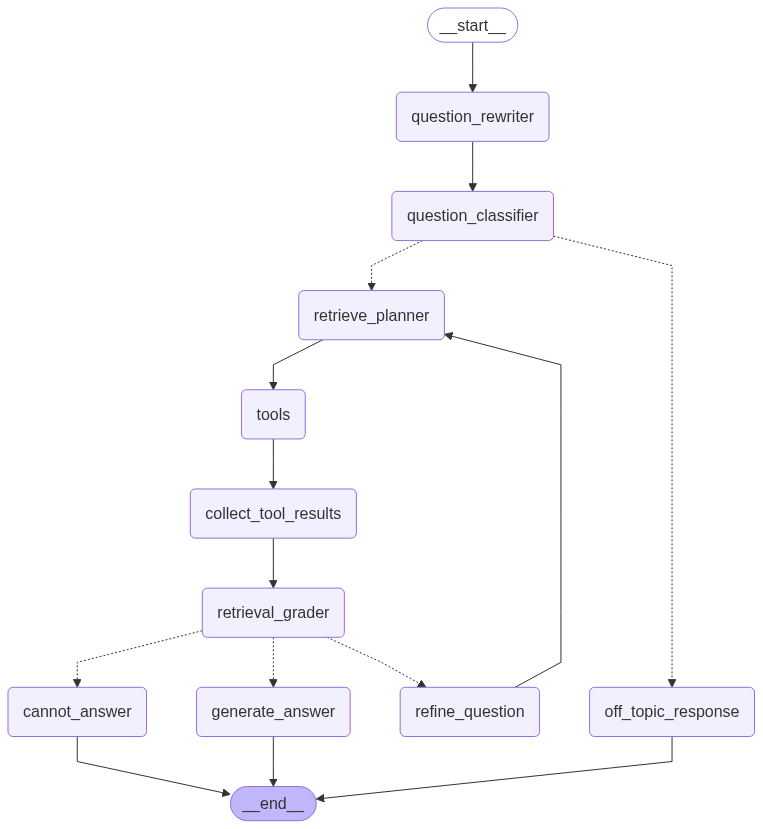

In [8]:
# Render the LangGraph state machine via Mermaid's hosted API (skip Pyppeteer)
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

g = graph.get_graph()

# PNG (fast + reliable)
png_bytes = g.draw_mermaid_png(draw_method=MermaidDrawMethod.API)
display(Image(data=png_bytes))



Pyppeteer render failed: Graph.draw_mermaid_png() got an unexpected keyword argument 'png_scale'
Falling back to API…


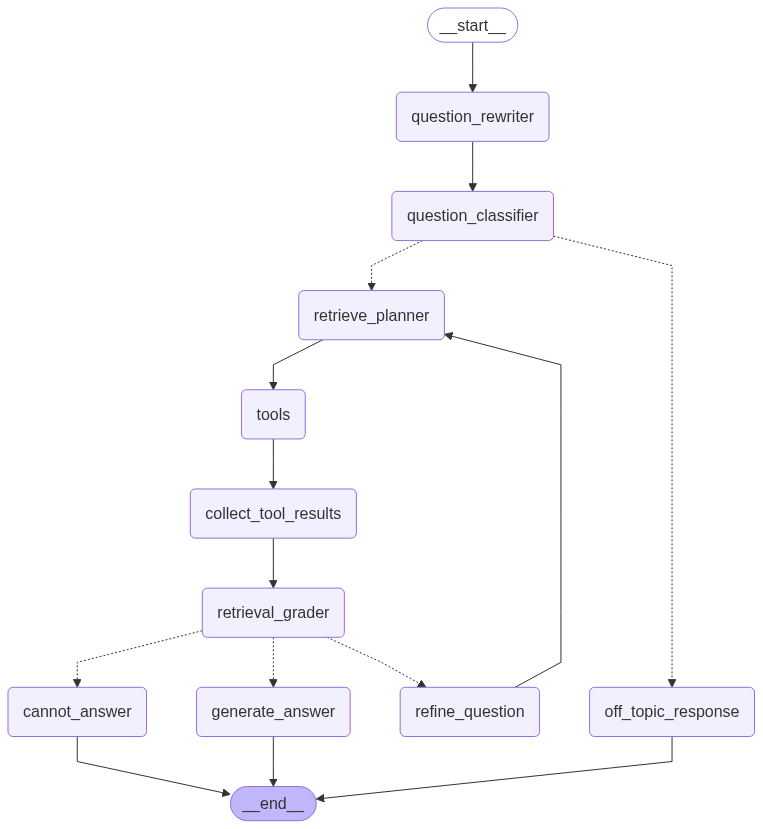


--- Mermaid source ---

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	question_rewriter(question_rewriter)
	question_classifier(question_classifier)
	off_topic_response(off_topic_response)
	retrieve_planner(retrieve_planner)
	tools(tools)
	collect_tool_results(collect_tool_results)
	retrieval_grader(retrieval_grader)
	generate_answer(generate_answer)
	refine_question(refine_question)
	cannot_answer(cannot_answer)
	__end__([<p>__end__</p>]):::last
	__start__ --> question_rewriter;
	collect_tool_results --> retrieval_grader;
	question_classifier -.-> off_topic_response;
	question_classifier -.-> retrieve_planner;
	question_rewriter --> question_classifier;
	refine_question --> retrieve_planner;
	retrieval_grader -.-> cannot_answer;
	retrieval_grader -.-> generate_answer;
	retrieval_grader -.-> refine_question;
	retrieve_planner --> tools;
	tools --> collect_tool_results;
	cannot_answer --> __end__;
	generate_answer --> __end__;
	off_top

In [6]:
# Cell 3 — visualize the LangGraph workflow (robust to no-internet)
# If you see "Event loop is closed" in notebooks, the nest_asyncio lines help.
import nest_asyncio, io
nest_asyncio.apply()

from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

g = graph.get_graph()

def show_graph():
    try:
        # Prefer LOCAL rendering (no internet) via headless Chromium
        png_bytes = g.draw_mermaid_png(
            draw_method=MermaidDrawMethod.PYPPETEER,  # <<< local renderer
            png_scale=1.5                              # crisper image
        )
        display(Image(data=png_bytes))
        # Optionally save it too
        with open("rice_agent_graph.png", "wb") as f:
            f.write(png_bytes)
        print("Saved diagram -> rice_agent_graph.png")
    except Exception as e:
        print(f"Pyppeteer render failed: {e}\nFalling back to API…")
        # Fallback to online service (works only if internet is allowed)
        png_bytes = g.draw_mermaid_png(draw_method=MermaidDrawMethod.API)
        display(Image(data=png_bytes))

show_graph()

# If you want the raw Mermaid source (useful to paste into mermaid.live)
mermaid_src = g.draw_mermaid()           # returns the Mermaid graph text
print("\n--- Mermaid source ---\n")
print(mermaid_src)


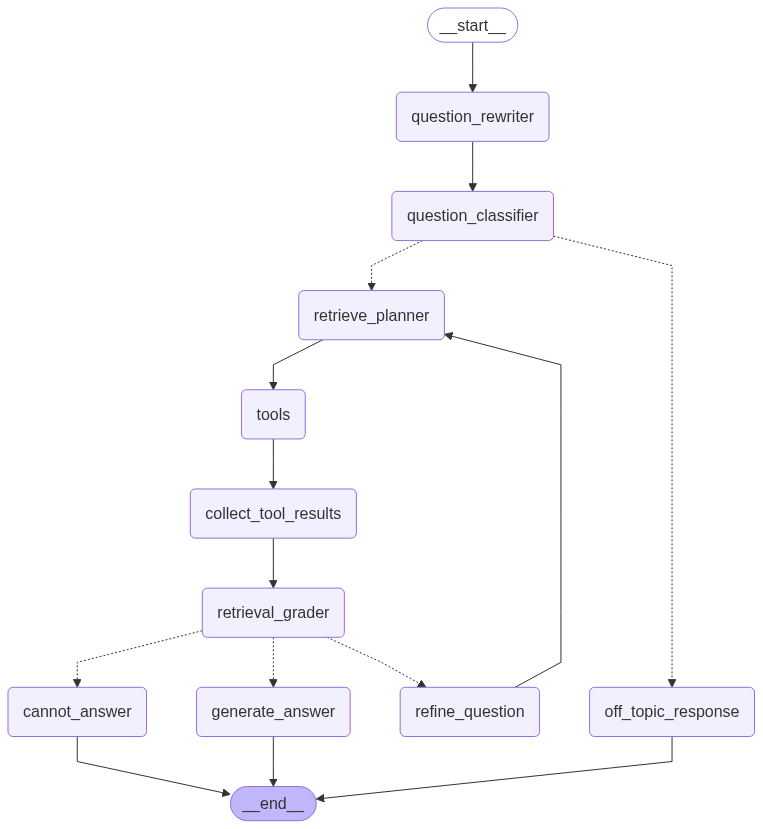

In [9]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

# Generate a visual representation of the state machine
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)
